#### This models what occurs in the systems, from a starting point of the drug being injected subcutaneously and how it behaves from there — the AD part of ADME.
- Focus on a two-part compartmentalization

goals
- figure out the general localization of the drug
- absorption modeling: intravenous injection. absorption is immediate and complete. model as a bolus input into the central compartment.
- distribution modeling: compartmentalized into central (blood), periphery (tissues), and tumor
- key considerations:
  - Tumor-homing ability: CAR-macrophages have an inherent ability to home to tumors. Incorporate this into your model using a parameter for preferential distribution to the tumor compartment5.
  - Limited circulation time: Unlike CAR-T cells, CAR-macrophages have a limited time in circulation. Account for this with appropriate elimination rates from the central compartment5.
  - Biodistribution: Model the tendency of macrophages to accumulate in the liver and lungs after administration7.
  - Lack of proliferation: Unlike CAR-T cells, CAR-macrophages do not proliferate post-administration. Your model should reflect this characteristic7.
  - Tumor microenvironment (TME) effects: Consider incorporating parameters that represent the impact of the TME on CAR-macrophage function and persistence
- how to quantify these effects:
  - Tumor compartment concentration: Model the concentration of CAR-macrophages in the tumor compartment over time.
  - Efficacy threshold: Define a threshold concentration or exposure metric (e.g., AUC) in the tumor compartment that correlates with efficacy based on preclinical data.
  - Sensitivity analysis: Perform sensitivity analyses to identify key parameters affecting tumor penetration and efficacy.
  - PK-PD linking: Develop a PD model that links the concentration of CAR-macrophages in the tumor to the therapeutic effect (e.g., reduction in IL-6 levels or tumor size)1.

why model the liver accumulation?
"The organ most likely to experience significant non-target effects from an injected CAR-macrophage therapy is the liver. This is supported by several factors:

Biodistribution Patterns: Studies have shown that macrophages, including CAR-macrophages, tend to accumulate in the liver after intravenous administration. This is due to the liver's role as a primary immune organ and its high content of macrophage-like Kupffer cells, which can trap and process foreign cells or particles12.

Potential Liver Toxicity: Elevated levels of inflammatory cytokines during therapies like CAR-T or CAR-M can lead to liver inflammation or transient increases in liver enzymes (e.g., bilirubin, ALT, AST), indicating hepatic stress or damage3. While CAR-macrophages are designed to reduce systemic cytokine release compared to CAR-T cells, the liver remains a key site for potential off-target effects.

Immune Cell Processing: The liver plays a central role in filtering and processing immune cells introduced into circulation. This natural immune surveillance function can lead to unintended interactions between CAR-macrophages and hepatic cells2.

Preclinical Observations: In animal models, CAR-macrophages have consistently shown significant accumulation in the liver after systemic administration, reinforcing this organ as a hotspot for biodistribution and potential non-target effects"

- alternatively or additionally, model the intestine: The organ most dependent on homeostatic levels of IL-6 is the intestine, particularly the small intestine. IL-6 plays a critical role in maintaining intestinal crypt homeostasis and epithelial regeneration through its interaction with Paneth cells and the Wnt signaling pathway. Here are the key reasons:

TODO
- SENSITIVITY ANALYSIS / PARAMETER SWEEP
- translate the perplexity code into Steve's format for readability
- find some rate constants to start on
- 

assumptions:
- treat the therapy like a drug being intravenously injected. no proliferation of cells, only such thing as excretion and regular as-expected interactions with the rest of the compartments

# Imports and useful functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [ ]:
Species = namedtuple('Species', ['description', 'initial_value', 'units'])

def state_variable_metadata(dosage=50e-6, V_delivery=0, V_central=1e-6, V_tumor=1e-6, V_periphery=1e-6):
    return {
        'C_delivery': Species(description="Concentration in delivery compartment", initial_value=dosage, units='M'),
        'C_central': Species(description="Concentration in central compartment", initial_value=0, units='M'),
        'C_tumor': Species(description="Concentration in tumor compartment", initial_value=0, units='M'),
        'C_periphery': Species(description="Concentration in periphery compartment", initial_value=0, units='M'),

        'V_delivery': Species(description="Volume in delivery compartment", initial_value=V_delivery, units='mL'),
        'V_central': Species(description="Volume in central compartment", initial_value=V_central, units='mL'),
        'V_tumor': Species(description="Volume in tumor compartment", initial_value=V_tumor, units='mL'),
        'V_periphery': Species(description="Volume in periphery compartment", initial_value=V_periphery, units='mL'),
    }

def rate_constants():
    return {
        # Define PK parameters
        'k_ABS': 0.5,             # Absorption rate constant
        'k_CP': 0.15,           # Rate constant from central to peripheral compartment
        'k_PC': 0.1,            # Rate constant from peripheral to central compartment
        'k_e_C': 0.05,            # Elimination from central compartment (limited circulation time)
        'k_CT': 0.2,            # Rate constant for central to tumor compartment (tumor homing)
        'k_e_T': 0.05,          # Rate constant for leaving the tumor compartment
        'k_TME': 0.05,          # TME effects reducing persistence in the tumor
        'k_CL': 0.1,         # Rate constant for accumulation in the liver from central compartment
        'dosage': 100,
    }

In [ ]:
def dydt(t, y, rate_constants, Species):
    values = dict( zip( Species.keys(), y ) )

    derivatives = dict()

    derivatives['C_delivery'] = (
        - rate_constants['k_ABS'] * values['C_delivery']
    )

    derivatives['C_central'] = (
        - rate_constants['k_ABS'] * values['C_delivery'] * values['IL-6']
        + rate_constants['k_off'] * values['Cs']
        - rate_constants['k_r,e'] * values['Rs']
        - rate_constants['k_r,p'] * values['Rs']
        + rate_constants['k_r,e,rec'] * values['Re']
        + rate_constants['k_r,p,rec'] * values['Rp']
        + rate_constants['V_s']
    )

    derivatives['C_peripheral'] = (
        rate_constants['k_on'] * values['Rs'] * values['IL-6']
        - rate_constants['k_off'] * values['Cs']
        - rate_constants['k_c,e'] * values['Cs']
        - rate_constants['k_c,p'] * values['Cs']
        + rate_constants['k_c,e,rec'] * values['Ce']
        + rate_constants['k_c,p,rec'] * values['Cp']
    )

    derivatives['C_tumor'] = (
        rate_constants['k_on'] * values['Rs'] * values['IL-6']
        - rate_constants['k_off'] * values['Cs']
        - rate_constants['k_c,e'] * values['Cs']
        - rate_constants['k_c,p'] * values['Cs']
        + rate_constants['k_c,e,rec'] * values['Ce']
        + rate_constants['k_c,p,rec'] * values['Cp']
    )

    derivatives['C_Liver'] = (
        rate_constants['k_on'] * values['Rs'] * values['IL-6']
        - rate_constants['k_off'] * values['Cs']
        - rate_constants['k_c,e'] * values['Cs']
        - rate_constants['k_c,p'] * values['Cs']
        + rate_constants['k_c,e,rec'] * values['Ce']
        + rate_constants['k_c,p,rec'] * values['Cp']
    )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in Species.keys()]


In [ ]:
def pk_model_updated(y, t, k_a, k_12, k_21, k_e, k_tumor, k_out_tumor, k_liver, k_lung, k_tme):
    dAdt = -k_a * y[0]  # Dosing compartment
    dCdt = (k_a * y[0] / V_c) - (k_12 + k_e + k_tumor + k_liver + k_lung + k_tme) * y[1] \
           + k_21 * y[2] + k_out_tumor * y[3]  # Central compartment
    dPdt = k_12 * y[1] - k_21 * y[2]  # Peripheral compartment
    dTdt = k_tumor * y[1] - (k_out_tumor + k_tme) * y[3]  # Tumor compartment
    dLiverdt = k_liver * y[1]  # Liver compartment (accumulation only)
    dLungdt = k_lung * y[1]  # Lung compartment (accumulation only)
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt, dLungdt]

# Time points for simulation
t = np.linspace(0, 48, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]
y0_updated = [dose, 0, 0, 0, 0, 0]

# Solve ODE for the updated model
solution_updated = odeint(pk_model_updated, y0_updated, t,
                          args=(k_a, k_12, k_21, k_e, k_tumor, k_out_tumor,
                                k_liver, k_lung, k_tme))

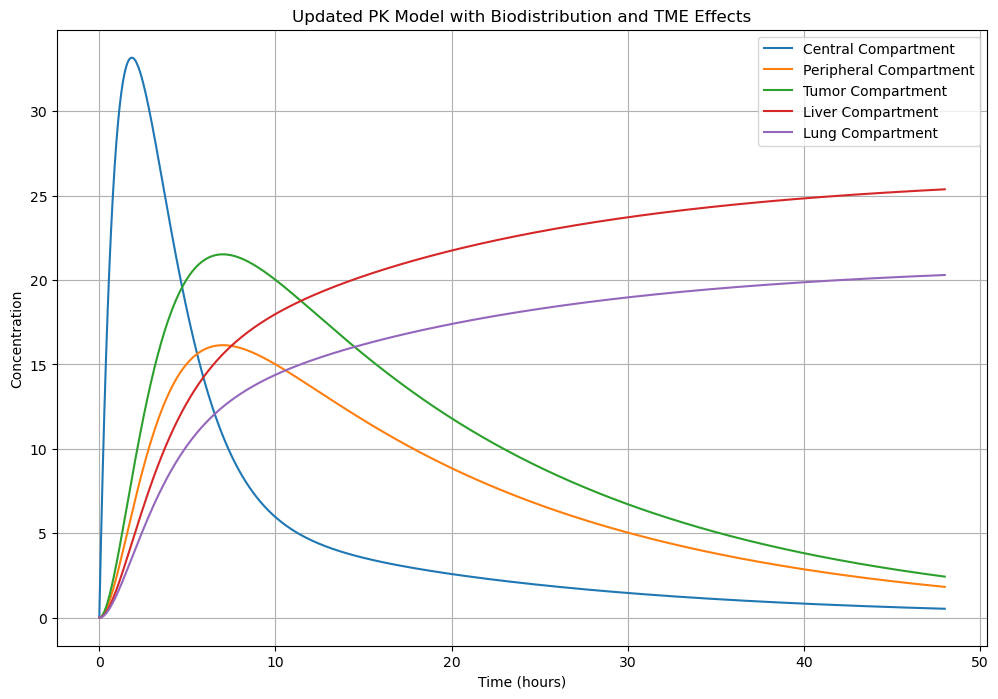

AUC in Tumor Compartment: 483.14
Efficacy Threshold Met: Yes


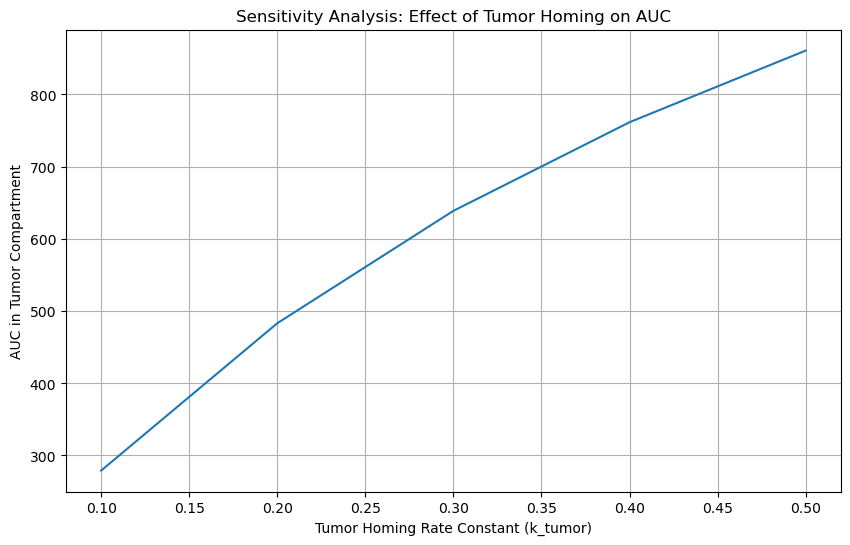

In [ ]:
# perplexity generated
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define PK parameters
k_a = 0.5  # Absorption rate constant
k_12 = 0.15  # Rate constant from central to peripheral compartment
k_21 = 0.1  # Rate constant from peripheral to central compartment
k_e = 0.05  # Elimination rate constant (limited circulation time)
k_tumor = 0.2  # Rate constant for tumor homing
k_out_tumor = 0.05  # Rate constant for leaving the tumor compartment
k_liver = 0.1  # Rate constant for accumulation in the liver
k_lung = 0.08  # Rate constant for accumulation in the lungs
k_tme = 0.05  # TME effects reducing persistence in the tumor

V_c = 1.0  # Volume of central compartment
V_tumor = 0.5  # Volume of tumor compartment
dose = 100  # Initial dose

# Define the updated multi-compartment model with biodistribution and TME effects
def pk_model_updated(y, t, k_a, k_12, k_21, k_e, k_tumor, k_out_tumor, k_liver, k_lung, k_tme):
    dAdt = -k_a * y[0]  # Dosing compartment
    dCdt = (k_a * y[0] / V_c) - (k_12 + k_e + k_tumor + k_liver + k_lung + k_tme) * y[1] \
           + k_21 * y[2] + k_out_tumor * y[3]  # Central compartment
    dPdt = k_12 * y[1] - k_21 * y[2]  # Peripheral compartment
    dTdt = k_tumor * y[1] - (k_out_tumor + k_tme) * y[3]  # Tumor compartment
    dLiverdt = k_liver * y[1]  # Liver compartment (accumulation only)
    dLungdt = k_lung * y[1]  # Lung compartment (accumulation only)
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt, dLungdt]

# Time points for simulation
t = np.linspace(0, 48, 1000)  # Simulate over 48 hours with fine resolution

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]
y0_updated = [dose, 0, 0, 0, 0, 0]

# Solve ODE for the updated model
solution_updated = odeint(pk_model_updated, y0_updated, t,
                          args=(k_a, k_12, k_21, k_e, k_tumor, k_out_tumor,
                                k_liver, k_lung, k_tme))

# Plot results for all compartments
plt.figure(figsize=(12, 8))
plt.plot(t, solution_updated[:, 1], label='Central Compartment')
plt.plot(t, solution_updated[:, 2], label='Peripheral Compartment')
plt.plot(t, solution_updated[:, 3], label='Tumor Compartment')
plt.plot(t, solution_updated[:, 4], label='Liver Compartment')
plt.plot(t, solution_updated[:, 5], label='Lung Compartment')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Updated PK Model with Biodistribution and TME Effects')
plt.legend()
plt.grid(True)
plt.show()

# Quantify Tumor Penetration and Efficacy

# Define efficacy threshold for tumor compartment concentration
efficacy_threshold = 10.0

# Calculate Area Under the Curve (AUC) for tumor compartment
def calculate_auc(concentration, time):
    return np.trapz(concentration, time)

auc_tumor = calculate_auc(solution_updated[:, 3], t)

# Check if efficacy threshold is met
efficacy_met = np.max(solution_updated[:, 3]) >= efficacy_threshold

print(f"AUC in Tumor Compartment: {auc_tumor:.2f}")
print(f"Efficacy Threshold Met: {'Yes' if efficacy_met else 'No'}")

# Sensitivity Analysis

# Define a function to run the model and calculate AUC for tumor compartment
def run_model_and_calculate_auc(k_tumor_val):
    solution_sa = odeint(pk_model_updated, y0_updated,
                         t,
                         args=(k_a,
                               k_12,
                               k_21,
                               k_e,
                               k_tumor_val,
                               k_out_tumor,
                               k_liver,
                               k_lung,
                               k_tme))
    auc_sa = calculate_auc(solution_sa[:, 3], t)
    return auc_sa

# Perform sensitivity analysis on tumor homing parameter (k_tumor)
k_tumor_values = np.linspace(0.1, 0.5, num=5)   # Test values for sensitivity analysis
auc_results = [run_model_and_calculate_auc(k) for k in k_tumor_values]

# Plot sensitivity analysis results
plt.figure(figsize=(10, 6))
plt.plot(k_tumor_values, auc_results)
plt.xlabel('Tumor Homing Rate Constant (k_tumor)')
plt.ylabel('AUC in Tumor Compartment')
plt.title('Sensitivity Analysis: Effect of Tumor Homing on AUC')
plt.grid(True)
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from collections import namedtuple

def make_plot_look_good(axes):
    axes.axhline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.axvline(0, color=[0.2, 0.2, 0.2], linewidth=1)
    axes.grid(True, which='both', linestyle='--', linewidth=0.5)
    for spine in axes.spines.values():
        spine.set_visible(False)

def set_axes_labels(axes, x_label, y_label, title, legend_title=None, fontsize=7):
    axes.set_xlabel(x_label, fontsize=fontsize)
    axes.set_ylabel(y_label, fontsize=fontsize)
    axes.set_title(title, fontsize=fontsize)
    if legend_title is not None:
        axes.legend(title=legend_title,bbox_to_anchor=(1,1))
    make_plot_look_good(axes)


def simulate_binding_recycling_and_degradation(t, rate_constants, Species):
    # concatenate state variable initial values into a list
    x_initial_value = np.array( [ iv.initial_value for iv in Species.values() ] )

    # call solve_ivp. this problem is stiff, so it is necessary to use an algorithm that can handle stiff systems.
    solution = solve_ivp(dydt, [t[0], t[-1]], x_initial_value,
                         args=(rate_constants, Species),
                         t_eval=t,
                         atol=1e-40,
                         dense_output=True,
                         method='Radau')

    # create a dictionary with keys equal to state variable names and values equal to simulation
    # this is handy for plotting or just accessing the state variable values
    simulation_results_dictionary = dict( (key, value) for key, value in zip(Species.keys(), solution.y) )
    # add time axis to results
    simulation_results_dictionary['t'] = t

    return simulation_results_dictionary, solution



# Simulation information: species and rate constants

In [ ]:
# using the two part compartmentalization that we learned in 20.320
#number_of_cells = 1e9
#avogadros_number = 6.022e23
#blood_volume = 4 # liters
#initial_receptor_concentration = number_of_cells * initial_receptors_per_cell / avogadros_number / blood_volume

Species = namedtuple('Species', ['description', 'initial_value', 'units'])

def state_variable_metadata(C_perfused=50e-6, C_target=0, V_perfused=1e-6, V_target=1e-6):
    return {
        'C_perfused': Species(description="Concentration in perfused compartment", initial_value=C1, units='M'),
        'C_target': Species(description="Concentration in target compartment", initial_value=0, units='M'),

        'V_perfused': Species(description="Volume of perfused compartment", initial_value=0, units='M'),
        'V_target': Species(description="Volume of target compartment", initial_value=0, units='M'),
    }


# wrapper for constants, to make looping easier later
def rate_constants(k_arterial=9.7e7, k_venous=0.24, V_s=100):
    return {
        # IL-6 association with Ab
        'k_arterial': k_arterial,       # /(M min)
        'k_venous': k_venous,        # /min

        # endocytosis and recycling and degradation
        'k_r,e': 0.08,     # receptor that is endocytosed
        'k_c,e': 0.03,     # complex that is endocytosed
        'k_r,e,rec':0,     # receptor that is endocytosed then recycled
        'k_c,e,rec':0,     # complex that is endocytosed then recycled
        'k_r,e,deg':0,     # receptor that is endocytosed then degraded
        'k_c,e,deg':0,     # complex that is endocytosed then degraded

        # phagocytosis and recycling and degradation
        'k_r,p': 0.08,     # receptor that is phagocytosed
        'k_c,p': 0.03,     # complex that is phagocytosed
        'k_r,p,rec':0,     # receptor that is phagocytosed then recycled
        'k_c,p,rec':0,     # complex that is phagocytosed then recycled
        'k_r,p,deg':0,     # receptor that is phagocytosed then degraded
        'k_c,p,deg':0,     # complex that is phagocytosed then degraded

        # synthesis of surface CAR
        'V_s': V_s,  # #/(cell min)    assume a few orders less than initial receptor concentration

        # cytokine release syndrome
        'k_crs': 1     # rate of release of IL-6 due to cytokine release syndrome; M/min
    }


# Implement rate equations

In [1]:

def dydt(t, y, rate_constants, Species):
    values = dict( zip( Species.keys(), y ) )

    derivatives = dict()

    derivatives['IL-6'] = (
        -rate_constants['k_on'] * values['Rs'] * values['IL-6']
        + rate_constants['k_off'] * values['Cs']
        + rate_constants['k_crs']
    )

    # SURFACE DERIVATIVES
    derivatives['Rs'] = (
        -rate_constants['k_on'] * values['Rs'] * values['IL-6']
        + rate_constants['k_off'] * values['Cs']
        - rate_constants['k_r,e'] * values['Rs']
        - rate_constants['k_r,p'] * values['Rs']
        + rate_constants['k_r,e,rec'] * values['Re']
        + rate_constants['k_r,p,rec'] * values['Rp']
        + rate_constants['V_s']
    )

    derivatives['Cs'] = (
        rate_constants['k_on'] * values['Rs'] * values['IL-6']
        - rate_constants['k_off'] * values['Cs']
        - rate_constants['k_c,e'] * values['Cs']
        - rate_constants['k_c,p'] * values['Cs']
        + rate_constants['k_c,e,rec'] * values['Ce']
        + rate_constants['k_c,p,rec'] * values['Cp']
    )

    # ENDOCYTOSED DERIVATIVES
    derivatives['Re'] = (
        rate_constants['k_r,e'] * values['Rs']
        - rate_constants['k_r,e,rec'] * values['Re']
        - rate_constants['k_r,e,deg'] * values['Re']
    )

    derivatives['Ce'] = (
        rate_constants['k_c,e'] * values['Cs']
        - rate_constants['k_c,e,rec'] * values['Ce']
        - rate_constants['k_c,e,deg'] * values['Ce']
    )
    
    # PHAGOCYTOSED DERIVATIVES
    derivatives['Rp'] = (
        rate_constants['k_r,p'] * values['Rs']
        - rate_constants['k_r,p,rec'] * values['Rp']
        - rate_constants['k_r,p,deg'] * values['Rp']
    )

    derivatives['Cp'] = (
        rate_constants['k_c,p'] * values['Cs']
        - rate_constants['k_c,p,rec'] * values['Cp']
        - rate_constants['k_c,p,deg'] * values['Cp']
    )

    # convert the 'derivatives' dictionary back to a vector because that is what solve_ivp requires
    return [ derivatives[key] for key in Species.keys()]


# Run the simulation with parameter sweep to characterize biological response

In [115]:
# define extent of parameter sweep

# initial ligand concentrations (M)
ligands = [0, 50e-10, 50e-6]     # 0 reflects absence of EGF

# initial EGFR and HER2 (#/cell)
r1ss = [50e2, 50e4, 50e6]
r2ss = [50e2, 50e4, 50e6]

# rate constants
k_cs = [1e-5, 1e-3, 1e-1]
k_ons=[9.7, 9.7e6, 9.7e10]
k_offs=[10e-6, 10e-2, 10]

## 1) Sweep over different initial concentrations, with fixed mid-sized rate constants

In [ ]:
SAVE_FIGS = False   # CHANGE TO FALSE IF YOU WANT TO DISPLAY PLOTS AND NOT DOWNLOAD THEM

# create time axis
simulation_time_mins = 10  # minutes
t = np.linspace(0, simulation_time_mins*60, 500)

for ligand in ligands:
    for r1s in r1ss:
        for r2s in r2ss:
            constants = rate_constants()
            metadata = state_variable_metadata(ligand=ligand, r1s=r1s, r2s=r2s)

            # Run the simulation
            simulation_results, solution = simulate_binding_recycling_and_degradation(t, constants, metadata)
            fig, axes = plt.subplots(5, 5, figsize=(8, 8), layout="constrained")
            axes = axes.flatten()
            fig.suptitle(f'[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell\n\n',
                         fontsize=8)


            plot_time_axis = simulation_results['t']/60

            for ax, (key, state_variable) in zip(axes,metadata.items()):
                ax.plot(plot_time_axis, simulation_results[key])

                set_axes_labels(ax, 'Time (min)', 'Concentration', state_variable.description, fontsize=7)
                make_plot_look_good(ax)

            axes[-1].set_visible(False)
            axes[-2].set_visible(False)
            if SAVE_FIGS:
                plt.savefig(f'all_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close(fig)
            else:
                plt.show()

            # make some overlay plots 
            for key, state_variable in metadata.items():
                if 's' in key and 'Ras' not in key:   # surface species
                    plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Surface species\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'surface_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()

            for key, state_variable in metadata.items():
                if 'i' in key:   # internal species
                    plt.plot(plot_time_axis, simulation_results[key], label=metadata[key].description)

            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Internal species\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'internal_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()

            # plot Ras-GTP only
            plt.plot(plot_time_axis, simulation_results['Ras-GTP'], label='Ras-GTP')
            plt.xlabel('Time (mins)')
            plt.ylabel('Concentration (#/cell)')
            plt.legend()
            plt.title(f'Ras-GTP\n[L]0: {ligand} M; [EGFR]0: {r1s} /cell; [HER2]0: {r2s} /cell')
            if SAVE_FIGS:
                plt.savefig(f'Ras_ligand_{ligand}_r1s_{r1s}_r2s_{r2s}.png', dpi=300)
                plt.close()
            else:
                plt.show()